In [2]:
# Importing packages and libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches 
import seaborn as sns 
from collections import Counter 
import os
import torch 
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader , random_split
from PIL import Image 
import copy
import xml.etree.ElementTree as ET
import xmltodict
import time
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm

c:\Users\ls97k\miniconda3\envs\torchenv-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
custom_palette =["#ff0000", "#00FF00", "#ffff00"]
sns.set_palette(custom_palette)

In [4]:
# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
img_names = []
xml_names = []

for dir_name, _, file_names in os.walk('../data/'):
    for file_name in file_names :
        if os.path.join(dir_name, file_name)[-3:]!='xml':
            img_names.append(file_name)
        else: 
            xml_names.append(file_name)

In [6]:
annotations_path = '../data/annotations/' 
listing = []

for img_name in img_names:
    xml_path = os.path.join(annotations_path, img_name[:-4] + ".xml")

    if os.path.exists(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall(".//object"):
            object_name = obj.find("name").text
            listing.append(object_name)

Items = Counter(listing).keys()
values = Counter(listing).values()

df = pd.DataFrame({'Mask Status': Items, 'Count': values})
print(df.sort_values(by='Count', ascending=False))

             Mask Status  Count
1              with_mask   3232
0           without_mask    717
2  mask_weared_incorrect    123


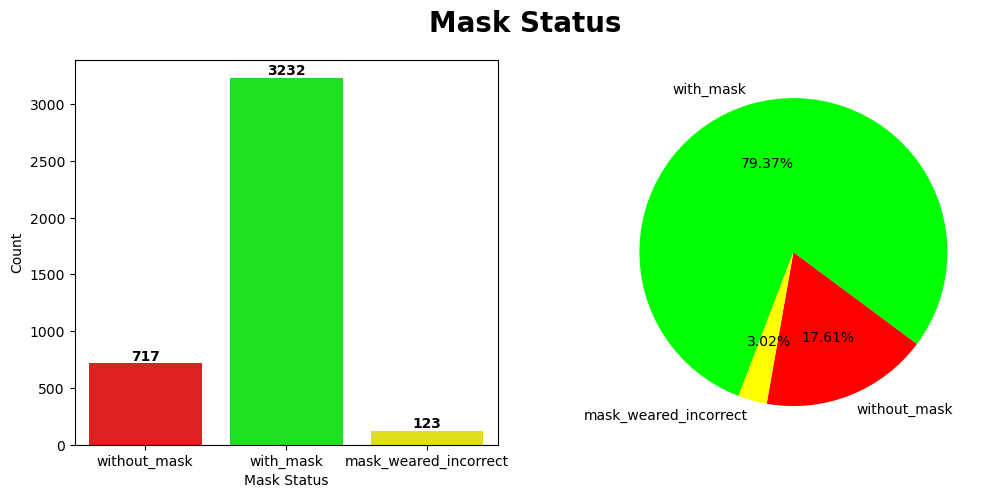

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.barplot(x="Mask Status", y="Count", data=df, ax=ax1)
for index, value in enumerate(df["Count"]):
    ax1.text(index, value, str(value), ha="center", va="bottom", fontweight="bold")

ax2.pie(df["Count"], labels=df["Mask Status"], autopct='%1.2f%%', startangle=-100, )

plt.suptitle("Mask Status", fontsize=20, fontweight="bold")
plt.show()

In [8]:
path_annotations = "../data/annotations/"
path_images = "../data/images/"

def parse_xml(xml_path):
    with open(xml_path) as fd:
        doc = xmltodict.parse(fd.read())
    return doc["annotation"]["object"]

def extract_bounding_box(obj_info):
    x, y, w, h = map(int, obj_info["bndbox"].values())
    return x, y, w, h

def draw_rectangle(ax, obj_info, obj_name):
    x, y, w, h = extract_bounding_box(obj_info)
    edgecolor = {"with_mask": custom_palette[1], "without_mask":  custom_palette[0], "mask_weared_incorrect":  custom_palette[2]}
    mpatch = mpatches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor=edgecolor[obj_name], facecolor="none", lw=2)
    ax.add_patch(mpatch)
    rx, ry = mpatch.get_xy()
    ax.annotate(obj_name, (rx, ry), color=edgecolor[obj_name], weight='bold', fontsize=10, ha='left', va='baseline')

def visualize_objects(img_name):
    xml_path = os.path.join(path_annotations, img_name[:-4] + ".xml")
    image_path = os.path.join(path_images, img_name)
    
    if os.path.exists(xml_path) and os.path.exists(image_path):
        obj_info = parse_xml(xml_path)
        image = plt.imread(image_path)

        fig, ax = plt.subplots(1)
        ax.axis("off")
        fig.set_size_inches(10, 5)

        if type(obj_info) == list:
            for obj in obj_info:
                draw_rectangle(ax, obj, obj["name"])
        else:
            draw_rectangle(ax, obj_info, obj_info["name"])

        ax.imshow(image)
        plt.show()


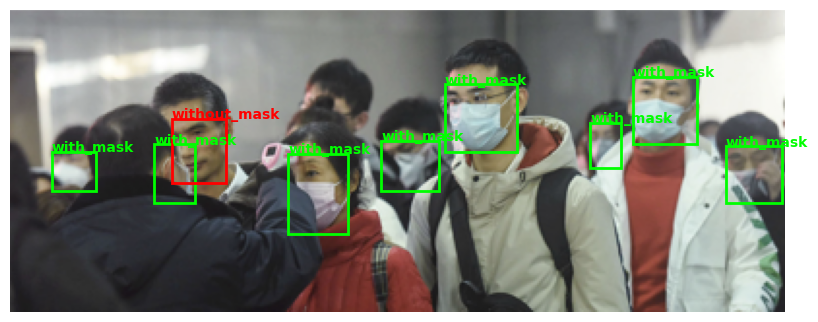

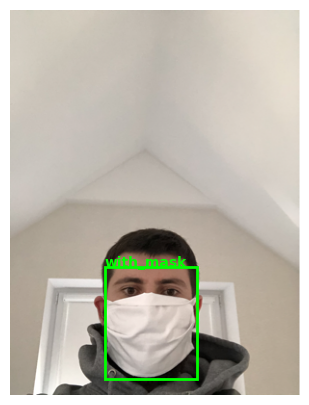

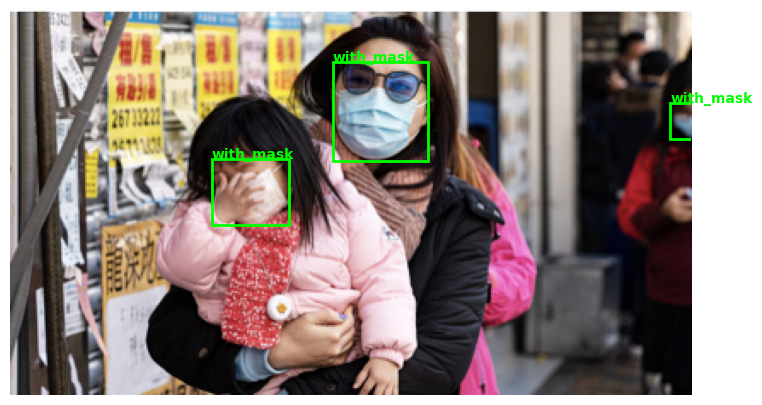

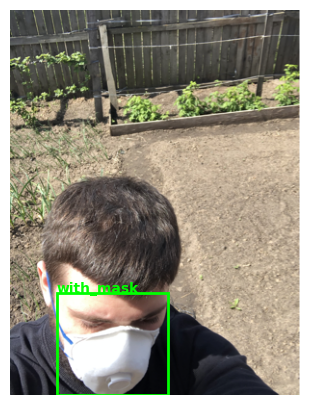

In [9]:
#  Images
fun_images = img_names.copy()
for i in range(1, 5):
    visualize_objects(fun_images[i])

### Image Pre-processing

In [10]:
def process_image(img_path, x, y, h, w, transform):
    image = transforms.functional.crop(
        Image.open(img_path).convert("RGB"), y, x, h - y, w - x
    )
    return transform(image)

def create_dataset_entry(xml_path, img_path, transform, label_mapping):
    obj_info = parse_xml(xml_path)
    if type(obj_info) != list:
        x, y, w, h = extract_bounding_box(obj_info)
        label = label_mapping[obj_info["name"]]
        image_tensor = process_image(img_path, x, y, h, w, transform)
        label_tensor = torch.tensor(label)
    else:
        image_tensor = []
        label_tensor = []
        for obj in obj_info:
            x, y, w, h = extract_bounding_box(obj)
            label = label_mapping[obj["name"]]
            image_tensor.append(process_image(img_path, x, y, h, w, transform))
            label_tensor.append(torch.tensor(label))
    
    return image_tensor, label_tensor

def dataset_creation(image_list, transform, label_mapping):
    final_dataset = []
    
    for img_name in image_list:
        xml_path = os.path.join(path_annotations, img_name[:-4] + ".xml")
        img_path = os.path.join(path_images, img_name)

        if os.path.exists(xml_path) and os.path.exists(img_path):
            image_tensor, label_tensor = create_dataset_entry(xml_path, img_path, transform, label_mapping)
            final_dataset.append([image_tensor, label_tensor])

    return tuple(final_dataset)

#transform and label mapping
transform = transforms.Compose([
    transforms.Resize((226, 226)),
    transforms.ToTensor()
])

options = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}

#dataset
my_df = dataset_creation(img_names, transform, options)


In [11]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_images+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_images+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

my_df=dataset_creation(img_names)

### Train - Test Split


In [12]:
# train = 75% and test = 25%
train_ratio = 0.75
total_size = len(my_df)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

print(f'Length of the Dataset : {len(my_df)}')
print(f'Length of the Training set : {train_size}')
print(f'Length of the Testing set : {test_size}')



#random split
train_df, test_df = random_split(my_df, [train_size, test_size])

train_dataloader = DataLoader(train_df, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_df, batch_size=32, shuffle=False, num_workers=4)

dataiter = iter(train_dataloader) 
features, labels = dataiter.next()
print(f'\nFeatures shape : {features.size()}, \nLabels shape : {labels.size()}')


Length of the Dataset : 4072
Length of the Training set : 3054
Length of the Testing set : 1018

Features shape : torch.Size([32, 3, 226, 226]), 
Labels shape : torch.Size([32])


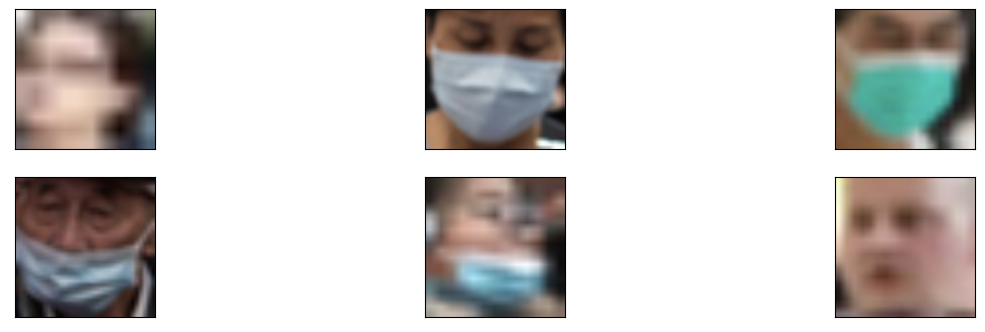

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

features_np = features.numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 4))

for idx, ax in enumerate(axes.flatten()):
    ax.imshow(np.transpose(features_np[idx], (1, 2, 0)))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### Model Building & Model Evaluation

In [14]:
def train_and_evaluate(model, criterion, optimizer, train_dataloader, test_dataloader, n_epochs, save_path):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    train_losses = []
    test_accuracies = []

    for epoch in range(n_epochs):
        print('\n'+f'Epoch {epoch} / {n_epochs - 1}')
        print('-' * 12)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for features, labels in tqdm(train_dataloader, desc="Training"):
            features, labels = features.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * features.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)
        train_losses.append(epoch_loss)

        print(f'Training Loss: {epoch_loss:.4f} | Training Accuracy: {epoch_acc:.4f}')

        test_accuracy = evaluate(model, test_dataloader, device)
        
        test_accuracies.append(test_accuracy)

        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            save_model(model, save_path)

    model.load_state_dict(best_model_wts)

    print("-" * 60)
    print("\t\tBest Model Evaluation:")
    print("-" * 60)
    print('\n')
    evaluate(model, test_dataloader, device)
    print(f"Best model saved at: {save_path}")

    # Training Loss
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

def evaluate(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

def save_model(model, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), save_path)  


Epoch 0 / 19
------------


Training: 100%|██████████| 96/96 [00:33<00:00,  2.88it/s]


Training Loss: 0.5376 | Training Accuracy: 0.8952


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]


Accuracy: 0.9460

Epoch 1 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.10it/s]


Training Loss: 0.0722 | Training Accuracy: 0.9768


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Accuracy: 0.9214

Epoch 2 / 19
------------


Training: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]


Training Loss: 0.0297 | Training Accuracy: 0.9921


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.74it/s]


Accuracy: 0.9568

Epoch 3 / 19
------------


Training: 100%|██████████| 96/96 [00:30<00:00,  3.10it/s]


Training Loss: 0.0172 | Training Accuracy: 0.9957


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Accuracy: 0.9509

Epoch 4 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0115 | Training Accuracy: 0.9964


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s]


Accuracy: 0.9450

Epoch 5 / 19
------------


Training: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]


Training Loss: 0.0081 | Training Accuracy: 0.9987


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.79it/s]


Accuracy: 0.9499

Epoch 6 / 19
------------


Training: 100%|██████████| 96/96 [00:30<00:00,  3.11it/s]


Training Loss: 0.0073 | Training Accuracy: 0.9990


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Accuracy: 0.9548

Epoch 7 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.08it/s]


Training Loss: 0.0036 | Training Accuracy: 0.9997


Evaluating: 100%|██████████| 32/32 [00:10<00:00,  3.02it/s]


Accuracy: 0.9548

Epoch 8 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.05it/s]


Training Loss: 0.0047 | Training Accuracy: 0.9987


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s]


Accuracy: 0.9607

Epoch 9 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0029 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.67it/s]


Accuracy: 0.9558

Epoch 10 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0017 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]


Accuracy: 0.9548

Epoch 11 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.07it/s]


Training Loss: 0.0017 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Accuracy: 0.9578

Epoch 12 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0014 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Accuracy: 0.9568

Epoch 13 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0015 | Training Accuracy: 0.9997


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Accuracy: 0.9538

Epoch 14 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0030 | Training Accuracy: 0.9993


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Accuracy: 0.9548

Epoch 15 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0034 | Training Accuracy: 0.9993


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Accuracy: 0.9548

Epoch 16 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0015 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.72it/s]


Accuracy: 0.9578

Epoch 17 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0015 | Training Accuracy: 0.9997


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]


Accuracy: 0.9597

Epoch 18 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.09it/s]


Training Loss: 0.0011 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.71it/s]


Accuracy: 0.9568

Epoch 19 / 19
------------


Training: 100%|██████████| 96/96 [00:31<00:00,  3.02it/s]


Training Loss: 0.0008 | Training Accuracy: 1.0000


Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.69it/s]


Accuracy: 0.9568
------------------------------------------------------------
		Best Model Evaluation:
------------------------------------------------------------




Evaluating: 100%|██████████| 32/32 [00:08<00:00,  3.64it/s]

Accuracy: 0.9607
Best model saved at: ../model/model.pth


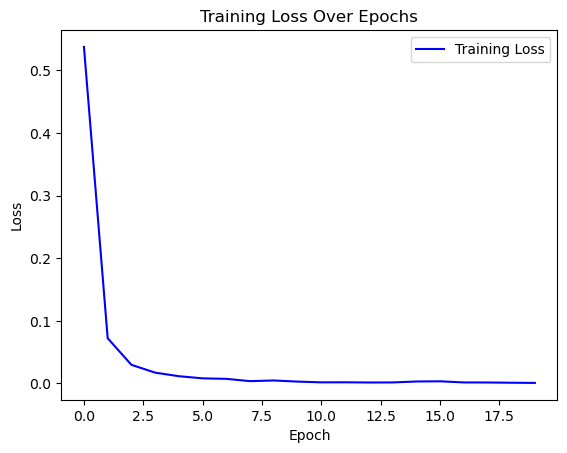

Training complete in 13m 29s


In [15]:
model = models.resnet34(pretrained = True)

num_features = model.fc.in_features
model.to(device)

learning_rate = 0.01
n_epochs=20

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

save_path = '../model/model.pth'

#training and evaluating
train_and_evaluate(model, criterion, optimizer, train_dataloader, test_dataloader, n_epochs=n_epochs, save_path=save_path)